#  Selección de atributos evolutiva para regresión

### Descripción

<font size="4"> Selección de atributos para regresión utilizando un algoritmo evolutivo (minimización).
    
### Componentes

- <font size="3"> Método wrapper con Random Forest y métrica MSE
    
- <font size="3"> Datos:
    
    - <font size="3"> Regresión

    - <font size="3"> Entradas numéricas y categóricas 
    
- <font size="3"> Algoritmo evolutivo:
    
    - <font size="3"> Representación binaria

    - <font size="3"> Selección por torneo binario

    - <font size="3"> Sustitución $(\mu+\lambda)$

    - <font size="3"> Cruce uniforme

    - <font size="3"> Mutación bit-flip

### Comentarios
    
- <font size="3"> Se leen los datos en formato arff.
    
- <font size="3"> Se imputan los missing values con la media (atributos numéricos) o la moda (atributos categóricos).
    
- <font size="3">  Para la evaluación de los modelos, los atributos de entrada categóricos se transforman a atributos binarios con one hot encoding.
    
- <font size="3">  Se requiere ordenar una población de $2 \cdot N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.
    
- <font size="3"> Aunque la tarea es de clasificación y por tanto el algoritmo maximiza la accuracy, se ha decidido dejar el algoritmo evolutivo para minimización de cara a no realizar cambios en el algoritmo base presentado en el curso. De esta forma, el algoritmo minimiza la accuracy negativa: 
    $$ Minimizar \ MSE$$    
    
    
---

### Requerimientos

In [20]:
import numpy as np
import heapq 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

### Lectura de los datos
#### Input:
  - $file\_path$: Nombre completo con path de la base de datos .arff a cargar
  
#### Output:
  - $X$: Atributos de entrada numéricos y categóricos
  - $y$: Salida numérica

In [21]:
def LoadData(file_path):

    data, meta = arff.loadarff(file_path) # necesitamos los metadatos para convertir la salida

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar atributos numéricos y categóricos
    numeric_attributes = df.iloc[:, :-1] .select_dtypes(include=['int', 'float']).columns
    categorical_attributes =  df.iloc[:, :-1].select_dtypes(include=['object']).columns

    # Imputación para atributos numéricos
    if numeric_attributes.size>0:
        df[numeric_attributes] = SimpleImputer(strategy='mean').fit_transform(df[numeric_attributes])
        
    # Imputación para atributos categóricos
    if categorical_attributes.size>0:
        df[categorical_attributes] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_attributes])

    # Separar en entradas (X) y salida (y)    
    X = df.iloc[:, :-1]
    
    # Salida: y
    y = df.iloc[:, -1]
        
    return X,y

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $p\_c$: Probabilidad de cruce
- $p\_m$: Probabilidad de mutación
- $random\_state$: Semilla para reproducibilidad
- $X,y$: Datos
- $Phi$: Algoritmo de aprendizaje para regresión
- $cv$: Cross Validation Folds

In [22]:
G = 100
N = 10
p_c = 0.7
p_m = 0.1
random_state=10

file_path = 'ICU_train.arff' # Atributos numéricos

X,y = LoadData(file_path)

Phi =  RandomForestRegressor(n_estimators=10, random_state=1)

# Dependiendo de la base de datos se debe utilizar un tipo u otro de folds
k = 5
cv = KFold(n_splits=k)

### Definición del problema de optimización

$\textit{Minimizar} \ f(\textbf{x}) = MSE(\textbf{x},D,\Phi,k)$
- $\textbf{x}=\{x_1,\ldots,x_n\}, x_l\in \{0,1\}$, es el vector de variables de decisión, donde cada componnte $x_l=1$ representa que el atributo $x_l$ ha sido seleccionado, siendo $n$ el número de atributos del conjunto de datos
- $D = (X,y)$: Conjunto de datos
- $\Phi$: Algoritmo de aprendizaje
- $k$: Número de folds para cross-validation (típicamente $k=5$)

In [23]:
def f(x,X,y,Phi,cv):
        
    if sum(x)==0: # Si no selecciona ningún attributo el mse es el peor (infinito)
        return float('inf')
    
    # Seleccionar atributos del dataset
    X_selected = X.iloc[:, np.where(x == 1)[0]]

    # Identificar los atributos categóricos
    X_selected_categorical = X_selected.select_dtypes(include=['object']).columns

    # Aplicar one hot encoding
    X_selected_encoded = pd.get_dummies(data=X_selected, columns=X_selected_categorical)    
    
    # Se evalúa el modelo en k-fold cross-validation    
    scores = cross_val_score(estimator=Phi, X=X_selected_encoded, y=y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    
    return -np.mean(scores)

### Definición de individuo

In [24]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n,dtype='int')
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [25]:
def InitializePopulation(P):
    n = P[0].x.size
    for I in P:    
        I.x[:] = np.random.randint(0,2,n)

### Función de evaluación

In [26]:
def evaluate(I,X,y,Phi,cv):
    I.f = f(I.x,X,y,Phi,cv)  # Se minimiza f(x)

### Copia de individuo

In [27]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f 

### Selección por torneo binario

In [28]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce
- Cruce uniforme con probabilidad $p\_c$

In [29]:
def crossover(x1,x2,p_c): 
    if np.random.random()<=p_c:
        for l in range(x1.size):
            if np.random.random()<=0.5:
                x1[l], x2[l] = x2[l], x1[l]     

### Mutación
- Mutación bit-flip con probabilidad $p\_m$

In [30]:
def mutation(x,p_m):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = 0 if x[l]==1 else 1

### Progreso del algoritmo

In [31]:
def IniciaProgreso(best_individuo,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(best_individuo,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(best_individuo,gen,best_outputs,progression_bar):
    mse = best_individuo.f
    num_selected = np.count_nonzero(best_individuo.x == 1)
    progression_bar.set_description("Generation: %s MSE cv: %s Selected: %s " % (str(gen), str(mse), str(num_selected)))
    best_outputs[gen] = best_individuo.f # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo evolutivo

In [32]:
def EA(G, N, p_c, p_m, X, y, Phi, cv, random_state):
    # Aserciones
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    assert p_c >= 0.0 and p_c <= 1.0, "La probablidad de cruce debe estar entre 0 y 1."  
    assert p_m >= 0.0 and p_m <= 1.0, "La probablidad de mutación debe estar entre 0 y 1."

    np.random.seed(random_state)
    n = len(X.T)    
    
    # Crear población inicial con N individuos
    P = [Individuo(n) for _ in range(N)]
    InitializePopulation(P)
    
    # Evaluar población inicial
    for I in P:
        evaluate(I,X,y,Phi,cv)
    
    # Crear población auxilar 
    Q = [Individuo(n) for _ in range(2*N)]
    
    # Evoluciona durante G generaciones
    best_outputs, progression_bar = IniciaProgreso(min(P),G)    
    for gen in range(1,G+1):
        for i in range(N):
            copia(Q[i],P[i])
        i=N
        while i < 2*N:
            copia(Q[i],binary_tournament_selection(P))
            copia(Q[i+1],binary_tournament_selection(P))
            crossover(Q[i].x,Q[i+1].x,p_c)
            mutation(Q[i].x,p_m)
            mutation(Q[i+1].x,p_m)
            evaluate(Q[i],X,y,Phi,cv)
            evaluate(Q[i+1],X,y,Phi,cv)
            i += 2  
        R = heapq.nsmallest(N,Q)
        for i in range(N):
            copia(P[i],R[i])
        ActualizaProgreso(P[0],gen,best_outputs,progression_bar)
    best_individuo = P[0]
    return best_outputs, best_individuo.f, best_individuo.x

### Ejecución del algoritmo evolutivo

In [33]:
%%time

best_outputs, best_f, best_solution = EA(G, N, p_c, p_m, X, y, Phi, cv, random_state)

print("x: ",best_solution)
print("RMSE cv: ",np.sqrt(best_f))
num_selected = np.count_nonzero(best_solution == 1)
print("Selected: ",num_selected)

Generation: 100 MSE cv: 0.13646995560392536 Selected: 5 : : 101it [01:35,  1.06it/s]

x:  [1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1]
RMSE cv:  0.36941840182092356
Selected:  5
CPU times: total: 17.3 s
Wall time: 1min 37s


### Visualización de la evolución del algoritmo

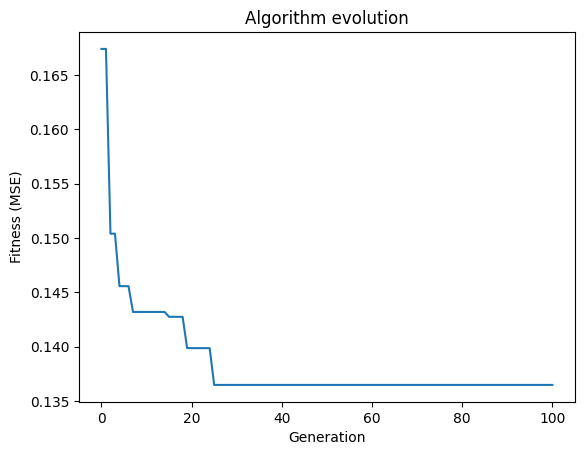

In [34]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Fitness (MSE)")
    plt.show()
    
VisualizaEvolucion(best_outputs)

### Solución con todos los atributos

In [35]:
n = len(X.T)
all_attributes = np.ones(n,dtype='int')
print("Número total de atributos:",n)
print("RMSE cv con todos los atributos: ",np.sqrt(f(all_attributes,X,y,Phi,cv)))

Número total de atributos: 19
RMSE cv con todos los atributos:  0.44902672526253934
